In [1]:
import os
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from __future__ import print_function
from PIL import Image
from os.path import join
import scipy.io
from torchvision.datasets.utils import download_url, list_dir, list_files

### dog face dataset load

In [2]:
class dogs(data.Dataset):
    """`Stanford Dogs <http://vision.stanford.edu/aditya86/ImageNetDogs/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``omniglot-py`` exists.
        cropped (bool, optional): If true, the images will be cropped into the bounding box specified
            in the annotations
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset tar files from the internet and
            puts it in root directory. If the tar files are already downloaded, they are not
            downloaded again.
    """
    folder = 'StanfordDogs'
    download_url_prefix = 'http://vision.stanford.edu/aditya86/ImageNetDogs'

    def __init__(self,
                 root,
                 train=True,
                 cropped=False,
                 transform=None,
                 target_transform=None,
                 download=False):

        self.root = join(os.path.expanduser(root), self.folder)
        self.train = train
        self.cropped = cropped
        self.transform = transform
        self.target_transform = target_transform

        if download:
            self.download()

        split = self.load_split()

        self.images_folder = join(self.root, 'Images')
        self.annotations_folder = join(self.root, 'Annotation')
        self._breeds = list_dir(self.images_folder)

        if self.cropped:
            self._breed_annotations = [[(annotation, box, idx)
                                        for box in self.get_boxes(join(self.annotations_folder, annotation))]
                                        for annotation, idx in split]
            self._flat_breed_annotations = sum(self._breed_annotations, [])

            self._flat_breed_images = [(annotation+'.jpg', idx) for annotation, box, idx in self._flat_breed_annotations]
        else:
            self._breed_images = [(annotation+'.jpg', idx) for annotation, idx in split]

            self._flat_breed_images = self._breed_images

        self.classes = ["Chihuaha",
                        "Japanese Spaniel",
                        "Maltese Dog",
                        "Pekinese",
                        "Shih-Tzu",
                        "Blenheim Spaniel",
                        "Papillon",
                        "Toy Terrier",
                        "Rhodesian Ridgeback",
                        "Afghan Hound",
                        "Basset Hound",
                        "Beagle",
                        "Bloodhound",
                        "Bluetick",
                        "Black-and-tan Coonhound",
                        "Walker Hound",
                        "English Foxhound",
                        "Redbone",
                        "Borzoi",
                        "Irish Wolfhound",
                        "Italian Greyhound",
                        "Whippet",
                        "Ibizian Hound",
                        "Norwegian Elkhound",
                        "Otterhound",
                        "Saluki",
                        "Scottish Deerhound",
                        "Weimaraner",
                        "Staffordshire Bullterrier",
                        "American Staffordshire Terrier",
                        "Bedlington Terrier",
                        "Border Terrier",
                        "Kerry Blue Terrier",
                        "Irish Terrier",
                        "Norfolk Terrier",
                        "Norwich Terrier",
                        "Yorkshire Terrier",
                        "Wirehaired Fox Terrier",
                        "Lakeland Terrier",
                        "Sealyham Terrier",
                        "Airedale",
                        "Cairn",
                        "Australian Terrier",
                        "Dandi Dinmont",
                        "Boston Bull",
                        "Miniature Schnauzer",
                        "Giant Schnauzer",
                        "Standard Schnauzer",
                        "Scotch Terrier",
                        "Tibetan Terrier",
                        "Silky Terrier",
                        "Soft-coated Wheaten Terrier",
                        "West Highland White Terrier",
                        "Lhasa",
                        "Flat-coated Retriever",
                        "Curly-coater Retriever",
                        "Golden Retriever",
                        "Labrador Retriever",
                        "Chesapeake Bay Retriever",
                        "German Short-haired Pointer",
                        "Vizsla",
                        "English Setter",
                        "Irish Setter",
                        "Gordon Setter",
                        "Brittany",
                        "Clumber",
                        "English Springer Spaniel",
                        "Welsh Springer Spaniel",
                        "Cocker Spaniel",
                        "Sussex Spaniel",
                        "Irish Water Spaniel",
                        "Kuvasz",
                        "Schipperke",
                        "Groenendael",
                        "Malinois",
                        "Briard",
                        "Kelpie",
                        "Komondor",
                        "Old English Sheepdog",
                        "Shetland Sheepdog",
                        "Collie",
                        "Border Collie",
                        "Bouvier des Flandres",
                        "Rottweiler",
                        "German Shepard",
                        "Doberman",
                        "Miniature Pinscher",
                        "Greater Swiss Mountain Dog",
                        "Bernese Mountain Dog",
                        "Appenzeller",
                        "EntleBucher",
                        "Boxer",
                        "Bull Mastiff",
                        "Tibetan Mastiff",
                        "French Bulldog",
                        "Great Dane",
                        "Saint Bernard",
                        "Eskimo Dog",
                        "Malamute",
                        "Siberian Husky",
                        "Affenpinscher",
                        "Basenji",
                        "Pug",
                        "Leonberg",
                        "Newfoundland",
                        "Great Pyrenees",
                        "Samoyed",
                        "Pomeranian",
                        "Chow",
                        "Keeshond",
                        "Brabancon Griffon",
                        "Pembroke",
                        "Cardigan",
                        "Toy Poodle",
                        "Miniature Poodle",
                        "Standard Poodle",
                        "Mexican Hairless",
                        "Dingo",
                        "Dhole",
                        "African Hunting Dog"]




    def __len__(self):
        return len(self._flat_breed_images)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target character class.
        """
        image_name, target_class = self._flat_breed_images[index]
        image_path = join(self.images_folder, image_name)
        image = Image.open(image_path).convert('RGB')

        if self.cropped:
            image = image.crop(self._flat_breed_annotations[index][1])

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            target_class = self.target_transform(target_class)

        return image, target_class

    def download(self):
        import tarfile

        if os.path.exists(join(self.root, 'Images')) and os.path.exists(join(self.root, 'Annotation')):
            if len(os.listdir(join(self.root, 'Images'))) == len(os.listdir(join(self.root, 'Annotation'))) == 120:
                print('Files already downloaded and verified')
                return

        for filename in ['images', 'annotation', 'lists']:
            tar_filename = filename + '.tar'
            url = self.download_url_prefix + '/' + tar_filename
            download_url(url, self.root, tar_filename, None)
            print('Extracting downloaded file: ' + join(self.root, tar_filename))
            with tarfile.open(join(self.root, tar_filename), 'r') as tar_file:
                tar_file.extractall(self.root)
            os.remove(join(self.root, tar_filename))

    @staticmethod
    def get_boxes(path):
        import xml.etree.ElementTree
        e = xml.etree.ElementTree.parse(path).getroot()
        boxes = []
        for objs in e.iter('object'):
            boxes.append([int(objs.find('bndbox').find('xmin').text),
                          int(objs.find('bndbox').find('ymin').text),
                          int(objs.find('bndbox').find('xmax').text),
                          int(objs.find('bndbox').find('ymax').text)])
        return boxes

    def load_split(self):
        if self.train:
            split = scipy.io.loadmat(join(self.root, 'train_list.mat'))['annotation_list']
            labels = scipy.io.loadmat(join(self.root, 'train_list.mat'))['labels']
        else:
            split = scipy.io.loadmat(join(self.root, 'test_list.mat'))['annotation_list']
            labels = scipy.io.loadmat(join(self.root, 'test_list.mat'))['labels']

        split = [item[0][0] for item in split]
        labels = [item[0]-1 for item in labels]
        return list(zip(split, labels))

    def stats(self):
        counts = {}
        for index in range(len(self._flat_breed_images)):
            image_name, target_class = self._flat_breed_images[index]
            if target_class not in counts.keys():
                counts[target_class] = 1
            else:
                counts[target_class] += 1

        print("%d samples spanning %d classes (avg %f per class)"%(len(self._flat_breed_images), len(counts.keys()), float(len(self._flat_breed_images))/float(len(counts.keys()))))

        return counts

### hyper parameter setting

In [3]:
h_p = {
    'lr': 2e-4,
    'betas': (0.5, 0.999),
    'z_dim': 100,
    'device': "cuda" if torch.cuda.is_available() else "cpu",
    'epochs': 5,
    'img_size': 32,
    'criterion': nn.BCELoss(),
    'batch_size': 128,
    'img_channel': 1
}

### load dataset to dataloader

In [4]:
dir_name = "FashionMNIST_dataset"
os.makedirs(dir_name , exist_ok=True)
transform = transforms.Compose([
        transforms.Resize((h_p['img_size'], h_p['img_size'])), 
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (0.5,))
    ])
trainset = datasets.FashionMNIST(root=dir_name, transform=transform, download=True, train=True)
testset = datasets.FashionMNIST(root=dir_name, transform=transform, download=True, train=False)
trainloader = data.DataLoader(dataset=trainset, batch_size=h_p['batch_size'], shuffle=True)
testloader = data.DataLoader(dataset=testset, batch_size=h_p['batch_size'], shuffle=False)

# dir_name = "CIFAR10_dataset"
# os.makedirs(dir_name , exist_ok=True)
# transform = transforms.Compose([
#         transforms.Resize((hyper_param['img_size'], hyper_param['img_size'])), 
#         transforms.ToTensor(), 
#         transforms.Normalize((0.5,), (0.5,))
#     ])
# trainset = datasets.CIFAR10(root=dir_name, transform=transform, download=True, train=True)
# testset = datasets.CIFAR10(root=dir_name, transform=transform, download=True, train=False)
# trainloader = data.DataLoader(dataset=trainset, batch_size=h_p['batch_size'], shuffle=True)
# testloader = data.DataLoader(dataset=testset, batch_size=h_p['batch_size'], shuffle=False)


# dir_name = "stanford_dogs_dataset"
# os.makedirs(dir_name , exist_ok=True)
# transform = transforms.Compose([
#         transforms.RandomResizedCrop(224, ratio=(1, 1.3)),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor()
#         ])
# trainset = dogs(root=dir_name, train=True, cropped=False, transform=transform, download=True)
# testset = dogs(root=dir_name, train=False, cropped=False, transform=transform, download=True)
# train_loader = data.DataLoader(trainset, batch_size=h_p['batch_size'], shuffle=True)
# test_loader = data.DataLoader(testset, batch_size=h_p['batch_size'], shuffle=True)


### DCGAN model

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels):
        super().__init__()
        # DCGAN block
        def gen_block(in_channels, out_channels, kernal_size, stride, padding):
            return nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels, 
                    out_channels, 
                    kernal_size, 
                    stride, 
                    padding,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        self.model = nn.Sequential(
                *gen_block(z_dim, 1024, 2, 1, 0), #->2*2
                *gen_block(1024, 512, 4, 2, 1), #->4*4
                *gen_block(512, 256, 4, 2, 1), #->8*8
                *gen_block(256, 128, 4, 2, 1), #->16*16
                nn.ConvTranspose2d(128, img_channels, 4, 2, 1), #->32*32
                nn.Tanh(),
            )
    
    def init_weight(self):
        for m in self.model.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super().__init__()
        # DCGAN block
        def disc_block(in_channels, out_channels, kernal_size, stride, padding):
            return nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    out_channels, 
                    kernal_size, 
                    stride, 
                    padding, 
                    bias=False
                ),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2),
            )

        self.model = nn.Sequential(
                # Input: N * channels * 32 * 32
                nn.Conv2d(img_channels, 64, 4, 2, 1), #-> 16*16
                nn.LeakyReLU(0.2),
                *disc_block(64, 128, 4, 2, 1), #-> 8*8
                *disc_block(128, 256, 4, 2, 1), #-> 4*4
                *disc_block(256, 512, 4, 2, 1), #-> 2*2
                nn.Conv2d(512, 1, 2, 2, 0), # 1*1
                nn.Sigmoid(),
            )

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

    def forward(self, x):
        return self.model(x)

### model training

In [6]:
def GAN_training(model):
    progress = tqdm.tqdm(total=h_p['epochs'])
    loss_all = {'G_loss': [], 'D_loss':[]}
    start_time = time.time()
    for epoch in range(1, h_p['epochs']+1):
        for batch_idx, (real_img, label) in enumerate(trainloader):
            real_img = real_img.to(h_p['device'])
            noise = torch.randn((h_p['batch_size'], h_p['z_dim'], 1, 1)).to(h_p['device'])


            # 高斯distribution
            # Train Discriminator: max(E log(D(img)) + E log(1-D(G(z))))
            # G(z)
            fake_img = model['G'](noise)
            # D(img), D(G(z))
            D_real_img = model['D'](real_img).view(-1)
            D_fake_img = model['D'](fake_img).view(-1)
                
            # log(D(img)), log(1-D(G(z)))
            loss_D_real = h_p['criterion'](D_real_img, torch.ones_like(D_real_img))
            loss_D_fake = h_p['criterion'](D_fake_img, torch.zeros_like(D_fake_img))
            loss_D = (loss_D_real + loss_D_fake) / 2

            model['D'].zero_grad()
            loss_D.backward(retain_graph=True)
            model['optim_D'].step()

            output = model['D'](fake_img).view(-1)
            # Train Generator max(log(D(G(z)))
            loss_G = h_p['criterion'](output, torch.ones_like(output))

            model['G'].zero_grad()
            loss_G.backward()
            model['optim_G'].step()
            
        
            if batch_idx == len(trainloader) - 2:
                with torch.no_grad():
                    loss_all['G_loss'] += [loss_G.cpu().data.numpy()]
                    loss_all['D_loss'] += [loss_D.cpu().data.numpy()]
#                     clear_output(wait=True)
#                     plot_loss(opts['model_name'], **loss_all)

        progress.update(1)
        print(f"Epoch: [{epoch}/{h_p['epochs']}], G_Loss: [{loss_G: .4f}], D_Loss: [{loss_D: .4f}], time: [{time.time()-start_time}]")

        # if epoch == h_p['epochs']:
        fake_img = model['G'](model['fixed_noise'])
        t = transforms.Compose([transforms.Resize((28, 28))])
        fake_img = t(fake_img)
        fake_img_grid = torchvision.utils.make_grid(fake_img[:16], nrow=4, normalize=True)
        plt.imshow(fake_img_grid.permute(1, 2, 0).cpu().data.numpy())
        plt.show()

### main function

 20%|██        | 1/5 [06:38<26:32, 398.06s/it]

Epoch: [1/5], G_Loss: [ 0.6532], D_Loss: [ 0.6517], time: [398.8563930988312]


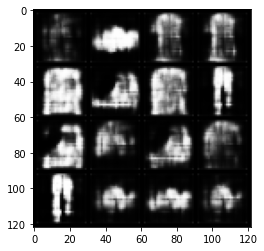

 40%|████      | 2/5 [13:17<19:57, 399.04s/it]

Epoch: [2/5], G_Loss: [ 0.7305], D_Loss: [ 0.6488], time: [798.5983066558838]


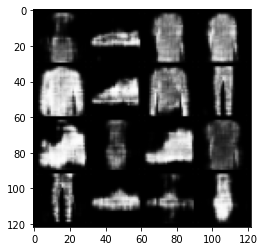

 60%|██████    | 3/5 [19:57<13:18, 399.25s/it]

Epoch: [3/5], G_Loss: [ 1.1917], D_Loss: [ 0.6003], time: [1198.0850703716278]


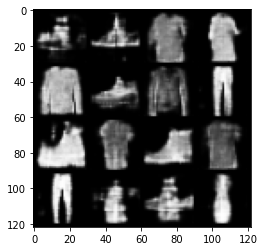

 80%|████████  | 4/5 [26:36<06:39, 399.31s/it]

Epoch: [4/5], G_Loss: [ 1.2243], D_Loss: [ 0.4496], time: [1597.5114567279816]


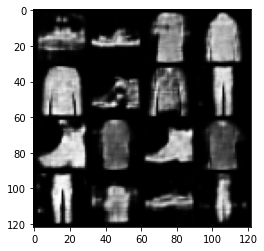

100%|██████████| 5/5 [33:16<00:00, 399.34s/it]

Epoch: [5/5], G_Loss: [ 2.2841], D_Loss: [ 0.1880], time: [1996.8935735225677]


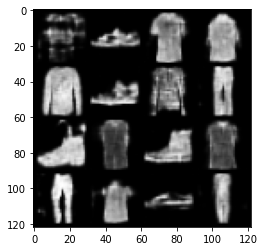

In [7]:
if __name__ == '__main__':
    # set up generator and discriminator and there optimizer
    G = Generator(h_p['z_dim'], h_p['img_channel'])
    D = Discriminator(h_p['img_channel'])
    G.init_weight()
    D.init_weight()
    G = G.model.to(h_p['device'])
    D = D.model.to(h_p['device'])
    optim_G = torch.optim.RMSprop(G.parameters(), lr=h_p['lr'])
    optim_D = torch.optim.RMSprop(D.parameters(), lr=h_p['lr'])
    fixed_noise = torch.randn(h_p['batch_size'], h_p['z_dim'], 1, 1).to(h_p['device'])
    G.train()
    D.train()
    model = {
        'G': G,
        'D': D,
        'optim_G': optim_G,
        'optim_D': optim_D,
        'fixed_noise': fixed_noise
    }
    GAN_training(model)